# Exposure Time Calculator 

Below is the code for version 1.5 of the exposure time calculator designed for POET. Current iteration is a working document and will be updated further as work progresses on POET. any inquiries about the workings of the ETC, or for bugs please contact me at nick.swidinsky@uleth.ca.

In [1]:
#%matplotlib notebook
#from ipywidgets import *
import numpy as np
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt
import statistics
import os
from astropy.io import fits #To read in FITS files and tables
import matplotlib



c = 2.998e8 #speed of light (m/s)
h = 6.626e-34 #Planck m^2 kg/s
Pi= np.pi*1.0 #define Pi
Rsun=695700000.0  # Radius of Sun (m)
zero_point = 25.6884
tput = 0.18 
aperture = 0.15
aperture2 = 2.4
gain = 6.1 #Photons needed for a single electron event 

def changeunits(flux):
    """
    Changes the units of flux from ergs/s/cm^2/nm to watts/m^2/nm. 
    Additional scale factor is used to match GAIA magnitude values.
    """
    try:
        fluxScaled = flux * 1e-7/(0.0001)*(4*np.pi)*6.898196982008417e-19
        return fluxScaled
    except: 
        return 0
    
    
def changeunitsA(flux, wavelength):
    """
    changes the units of flux from ergs/s/cm^2/A to watts/m^s/nm
    """
    newWavelength = wavelength /10
    fluxScaled = flux *1e-7/(0.0001)*10*6.898196982008417e-19
    
    return fluxScaled, newWavelength
    
    
def numericIntegration(x,y):
    """
    Function used to numerically integrate a function.
    
    Inputs:
        x: array of the x values of the curve
        y: array of the y values of the curve
        
    Output:
        total: Value of the numeric integration.
    """
    total = 0  #Add all of the areas to this to get the final integration 
    for i in range(len(x)-1):
        width = x[i+1]-x[i]
        height = y[i] + (y[i+1]-y[i])/2
        area = width*height
        total += area
    return total
    

In [2]:
##############################################################################################
###  Code to read in the ATLAS star data used for the ETC
##############################################################################################


grid_dir="../ck04models/" #base directory for ATLAS models

def getStarData(temperature, metallicity, logG):
    """
    Reads in star data from atlas directory, according to temperature, metallicity, and log(G) values.
    
    Inputs: 
        temperature: Temperature of the reference star in kelvin. Type: float
        metallicity: Metallicity of the reference star. Accepted inputs. 'p/m00','p/m05','p/m10','p/m15','p/m20'
                     p is plus, m is minus.
        logG: log(G) value for the reference star. Type: g00,g05,g10,g15,g20,g25,g30,g35,g40,g45,g50
    
    Outputs: 
        starFlux: flux of the reference star in units watts/m^2/nm. Type: array
        starWavelength: Wavelength of the reference star in nm. Type: array
    """


    mh=metallicity #metallicity 
    teff=temperature #3500 -- 13000 in steps of 250 K are available

    specfile=grid_dir+'ck'+mh+'/'+'ck'+mh+'_'+str(teff)+'.fits'
    if os.path.isfile(specfile):
        havespectrum=True
        hdul = fits.open(specfile)
        data = hdul[1].data #the first extension has table
        wv=data['WAVELENGTH'] #Units are Angstrom
        flux=data[logG] #Units are erg/s/cm^2/A
    else:
        havespectrum=False
        print('Spectrum not found: ',specfile)
        
    #extra plotting function for the star data.
    #if havespectrum:
    #    w1=2000
    #    w2=10000
    #    plt.plot(wv[(wv>w1)&(wv<w2)],flux[(wv>w1)&(wv<w2)])
    #    plt.xlabel('Wavelength (A)')
    #    plt.ylabel('Flux (erg/s/cm^2/A)')
    #    plt.show() 
    
    #change flux units to watts/m^2/nm and wavelength to nm
    starFlux, starWavelength = changeunitsA(flux, wv)
    
    return starFlux, starWavelength
    
   

In [3]:
#File path for some additional data files
filePath = '../GAIA_mag_data/'

def Photon_Count(temp, metallicity, logG, Wmin, Wmax, bandpass, bandpassWave, aperture, GAIA_mag, zero_point):
    """
    Generates noise for a planetary transit based on the orbiting star. Various star spectrums are read in 
    then selected based on what star type is selected. 
    
    Inputs:
        temp: Temperature of the reference star. Type: float
        metallicity: Metallicity of the reference star. Allowed inputs: 'p/m00','p/m05','p/m10','p/m15','p/m20'
                     p is plus, m is minus.
        logG: log(G) value for the reference star. Allowed inputs: g00,g05,g10,g15,g20,g25,g30,g35,g40,g45,g50
        Wmin: minumum wavelength of the bandpass. Type: float ##### This may change with changes to bandpass.
        Wmax: maximum wavelength of the bandpass. Type: float
        Bandpass: Bandpass of the filter being used. Type: float (Plan to incorporate arrays soon)
        gain: Number of photons needed for a single electron in the detector: Type: float
        aperture: Aperture size of the instrument. Type: float
        time: Time corresponding to the transit duration. Type: array
        transit: Transit function. This input will likely change in future iterations,
                 Currently used to create a function to apply noise to. Type: array
        GAIA_mag: GAIA magnitude of the desired star. Type: float
        zero_point: zero point for the GAIA magnitude. Type: float

    Outputs: 
        elecSec: The number of electrons read by the detector per second. Type: array
        countsAvg: Average number of photons read by the detector: type: float
        countsStdev: standard deviation of the counts read. Type: float
        noise: Electrons per second with added noise. Type: array
    
    """
    
    starFlux, starWavelength = getStarData(temp, metallicity, logG)
    starWavelength = np.asfarray(starWavelength, float)
    
    
    bot = np.where(starWavelength > (Wmin - 1))
    top = np.where(starWavelength > (Wmax-1))
    
    starFlux = starFlux[bot[0][0]:top[0][0]]
    starWavelength = starWavelength[bot[0][0]:top[0][0]]
    
   
    scale = 10**((GAIA_mag-zero_point)/-2.5) #Scale the flux using GAIA magnitudes, using VEGA as the model.
    scaled_flux = starFlux
    starflux = [i*scale for i in scaled_flux]#new star flux that has been scaled appropriately using G mag
        
    middle = len(starWavelength)//2
    photonCountRate = [] #create an array of the photon count over every wavelength, to be averaged over
    scaledWavelength = [] #convert wavelength from nm to m
    for i in range(len(bandpassWave)):
        scaledWavelength.append(bandpassWave[i]*1e-9)
        
    BPint = numericIntegration(x = scaledWavelength, y = bandpass)
    for i in range(len(starflux)):
        counts = starflux[i]*np.pi*aperture**2*(starWavelength[middle]*1e-9/(h*c))*BPint
        photonCountRate.append(counts)
    
    return photonCountRate

In [4]:
# read in POET potential targets csv file
# WANT TO READ IN:
# temp, metallicity, logG, GAIA_mag
def poetential(file):
    f = open(file, 'r')
    icount=0
    teff=[]  #stellar effective temperature   [5]
    metal=[] #stellar metallicity             [7]
    logg =[] #log G                           [6]
    gmag =[] #GAIA magnitude                  [17]

    for line in f:
        line = line.strip()
        columns = line.split(',') #break into columns  
        if(icount > 0):  #skip header info
            if ((str(columns[5])!='--') or (str(columns[7])!='--') or (str(columns[6])!='--') or (str(columns[17])!='--')):
                teff.append((columns[5])) #stellar effective temperature
                metal.append((columns[7])) #stellar metallicity
                logg.append((columns[6]))  #log G
                gmag.append((columns[17]))  #GAIA magnitude

        icount+=1
    f.close()
    teff=np.array(teff)
    metal=np.array(metal)
    logg=np.array(logg)
    gmag=np.array(gmag)
    
    return teff,metal,logg,gmag

# convert metal and logg from poet csv to valid inputs for photon_count
def conv_poet(m,l):
    nu_met=[]
    nu_logg=[]
    for i in range(len(m)):
        metal = m.astype(np.float64)
        if (float(metal[i])>0):
            sign='p'
        if (metal[i]<0):
            sign='m'
        if (abs(metal[i]<=0.025)):
            val='00'
        if (abs(metal[i])>0.025 and abs(metal[i])<=0.075):
            val='05'
        if (abs(metal[i])>0.075 and abs(metal[i])<=0.125):
            val='05'#should be 10
        if (abs(metal[i])>0.125 and abs(metal[i])<=0.175):
            val='20'#should be 15
        if (abs(metal[i])>0.175):
            val='20' 
        if (sign+val == 'm00'):
            sign='p'
        nu_met.append(sign+val)
    #g00,g05,g10,g15,g20,g25,g30,g35,g40,g45,g50    
    for i in range(len(l)):
        logg = l.astype(np.float64)
        if (abs(logg[i])<=2.5):
            val='g00'
        if (abs(logg[i])>2.5 and abs(logg[i])<=7.5):
            val='g05'
        if (abs(logg[i])>7.5 and abs(logg[i])<=12.5):
            val='g10'
        if (abs(logg[i])>12.5 and abs(logg[i])<=17.5):
            val='g15'
        if (abs(logg[i])>17.5 and abs(logg[i])<=22.5):
            val='g20'
        if (abs(logg[i])>22.5 and abs(logg[i])<=27.5):
            val='g25'
        if (abs(logg[i])>27.5 and abs(logg[i])<=32.5):
            val='g30'
        if (abs(logg[i])>32.5 and abs(logg[i])<=37.5):
            val='g35'
        if (abs(logg[i])>37.5 and abs(logg[i])<=42.5):
            val='g40'
        if (abs(logg[i])>42.5 and abs(logg[i])<=47.5):
            vanu_logg='g45'
        if (abs(logg[i])>47.5):
            val='g50'
        nu_logg.append(val)
            
    return nu_met,nu_logg
    
#checks list of ck04 teff models for closest value to given teff    
def teff_togrid(teff):
    teff=float(teff)
    #generate reference teff for ck04 models (/ck04models/ckXYY/)
    teff_grid=np.zeros(76,dtype=int)
    #250 step from 3500 to 13000
    for i in range(39):
        teff_grid[i]=3500+250*i
    #1000 step from 13000 to 50000
    for i in range(38):
        teff_grid[38+i]=13000+1000*i
    
    if (teff<=3500):
        nu_teff=teff_grid[0]
    else:
        for i in range(len(teff_grid)-1):
            if (teff<((teff_grid[i+1]+teff_grid[i])/2)) and (teff>=teff_grid[i]):
                nu_teff=teff_grid[i]
            if (teff>=((teff_grid[i+1]+teff_grid[i])/2)) and (teff<teff_grid[i+1]):
                nu_teff=teff_grid[i+1]
    
    return int(nu_teff)

In [5]:
#Additional files used for various purposes

#Bandpass data for the GAIA band
#colNamesPB = ['Wavelength', 'Gmag','GmagErr','bpPb','bpPbErr','rpPb','rpPbErr']
#PassBandData = pd.read_csv(f'{filePath}/GaiaDR2_RevisedPassbands.dat',delim_whitespace = True, names=colNamesPB,header=None)

#Data table with various data points, including G mag for various stars.  
GAIAtable = pd.read_csv(f'{filePath}nexsci_ctv10planets_05282019.csv', skiprows=82)

#read in potential POET targets
teff,metal,logg,gmag = poetential('../poetential_targets2.csv')
#convert metallicity and logG values to readable values by photon_count
metal,logg = conv_poet(metal,logg)
#print(teff,metal,logg,gmag)

#convert teff to ck04 model grid
ckm_teff=np.zeros(len(teff),dtype=int)
for i in range(len(teff)):
    ckm_teff[i]=teff_togrid(teff[i])


In [6]:
BPwv = np.arange(733,800,0.25).tolist()
BPwv = np.asfarray(BPwv, float)
bandpass = [0.2]*BPwv

############################################################################################################################################
#######       Function Call for the noise calculator function. Function uses the first magnitude in the nexsci table
############################################################################################################################################
    
time = np.arange(1,100,0.2).tolist() #Arbitrary time units to generate plot 
#sine graph currently used to demonstrate the noise for a curve. Once transit data is obtained that will be used.
sinwave = []
for i in range(len(time)):
    sinwave.append(np.sin(time[i]/(2*np.pi))+20)

#Get average photon count for A type star in the U,I and J band. 

#### Band can be selected by adjusting the Wmin and Wmax coordinates.
photonCountRate=[]
for i in range(len(teff)):
    pcr = Photon_Count(temp = ckm_teff[i], metallicity = metal[i], logG = logg[i], Wmin = 500, Wmax = 1000,
                               bandpass = bandpass,bandpassWave =BPwv, aperture = aperture,
                               GAIA_mag = float(gmag[i]),zero_point = zero_point)
    photonCountRate.append(pcr)
    
#print(photonCountRate)


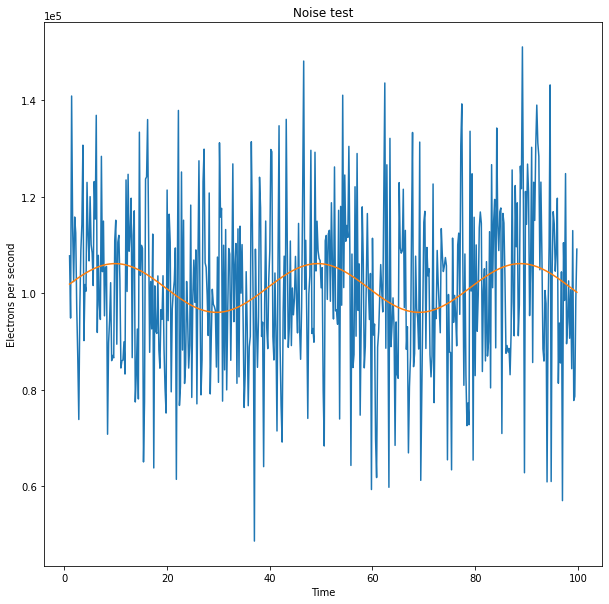

In [22]:
#Set whichever # target with 'it'. Starts at 0. Total of 501.
it=5
countsAvg = statistics.mean(photonCountRate[it])
countsStdev = statistics.stdev(photonCountRate[it])
    
elecSec = [i*countsAvg/gain for i in sinwave] #Currently transit is a seperate array, will likely change later when working on 2D data
mean_noise = 0
noise_calc = np.random.normal(mean_noise, np.sqrt(countsStdev)*200, len(elecSec))

noise = elecSec + noise_calc


fig = plt.figure(figsize=(10,10))
plt.title('Noise test')
plt.plot(time, noise)
plt.plot(time,elecSec)
plt.xlabel('Time')
plt.ylabel('Electrons per second')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.savefig('noisetest1.png', format='png', bbox_inches='tight')
plt.show()

In [13]:
#calculate average of noise for each i
noise_arr=np.zeros(len(teff))
for i in range(len(teff)):
    countsAvg = statistics.mean(photonCountRate[i])
    countsStdev = statistics.stdev(photonCountRate[i])
    elecSec = [j*countsAvg/gain for j in sinwave] #Currently transit is a seperate array, will likely change later when working on 2D data
    mean_noise = 0
    noise_calc = np.random.normal(mean_noise, np.sqrt(countsStdev)*200, len(elecSec))
    noise = elecSec + noise_calc
    noise_arr[i]=np.mean(noise)
print(np.mean(noise_arr))

1257032.163799806
